In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
plt.rcParams.update({'axes.labelsize': 16})
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

In [2]:
# draw functions

def draw_uniform(draw_set, draw_probs, n_sample = 10):
    sample = np.random.choice(draw_set, size=n_sample, replace=False, p=draw_probs)
    return sample

def draw_poisson(draw_set, draw_probs, mean = 4):
    n_sample = np.random.poisson(mean)
    sample = np.random.choice(draw_set, size=n_sample, replace=False, p=draw_probs)
    return sample

def draw_limit(draw_set, green_prob, n_limit=1):
    # draw until n_limit green marbles are drawn

    # first, let's make a copy to prevent anything weird
    _draw_set = np.array(draw_set.copy())
    # we have green_prob as an argument, other_prob will be one minus that
    other_prob = 1 - green_prob
    # make sure we enter the loop
    last_color = 'None'
    # make an empty list to store the sample
    sample = []
    # get the starting number of green and other marbles
    total_green_marbles = len(_draw_set[_draw_set=='Green'])
    total_other_marbles = len(_draw_set[_draw_set=='Other'])
 
    # while we haven't draw a green marble yet
    while last_color != 'Green':
        # first, recompute probabliities based on what is left in the bag
        # need current number of reen and other marbles left
        total_green_marbles = len(_draw_set[_draw_set=='Green'])
        total_other_marbles = len(_draw_set[_draw_set=='Other'])
        # compute weights for all marbles
        green_weights = np.ones(total_green_marbles) * green_prob / total_green_marbles #* (total_other_marbles/original_total)
        other_weights = np.ones(total_other_marbles) * other_prob / total_other_marbles #* (total_other_marbles/original_total)
        # compute the odds ratio
        odds_ratio = (green_prob / total_green_marbles) / (other_prob / total_other_marbles)
        # combine the probs into one array
        all_weights = np.concatenate((green_weights, other_weights))
        # print info for testing
        # print(len(_draw_set), len(all_weights), total_green_marbles, green_weights[0], other_weights[0], odds_ratio, green_weights.sum(), all_weights.sum())   
        # draw the index with the same probability as the marble
        index = np.random.choice(np.arange(len(_draw_set)), size=1, p=all_weights)
        # append the drawn marble to the set
        sample.append(_draw_set[index])
        # delete it from the bag
        _draw_set = np.delete(_draw_set,index)
        # store the last color
        last_color = sample[-1]

    return sample

In [3]:
x = np.array([1,2,3,4])
print(np.delete(x,0))
#print(x.delete(0))
print(x)

[2 3 4]
[1 2 3 4]


# The Wallenius' Noncentral Hypergeometric Distribution
This is a notebook demonstrating the use of Wallesnius' Noncentral Hypergeometric Distribution with some Bayesian inference. First, we will set up our bag of marbles. We are going to draw sets of marbles from the bag, hoping to get a green one versus a red one. But we know there are fewer green marbles than red ones. We draw a few times, and find we are getting more red marbles than we would expect (or maybe more) from just the simple ratio of the number of marbles.

We start to suspect there is foul play. What if these green marbles seem to actively avoid the hand pulling them out? So much so, that the there is a bias in the draw rates of green marbles versus other marbles. Let's investigate to see if we can detect this bias. 

In [17]:
# Left for posterity, clobbered in the main cell
total_marbles = 128
total_green_marbles = 32
total_other_marbles = total_marbles - total_green_marbles

green_prob = 0.2
other_prob = 0.8
green_weights = np.ones(total_green_marbles) * green_prob / total_green_marbles
other_weights = np.ones(total_other_marbles) * other_prob / total_other_marbles
print(f"prob to draw any green: {np.sum(green_weights):.2f}")
print(f"prob to draw any other: {np.sum(other_weights):.2f}")

# calculate odds ratio 
print(f"Odds ratio: {green_weights[0]/other_weights[0]:.2f}")

marble_set = total_green_marbles * ['Green'] + total_other_marbles * ['Other']
all_weights = np.concatenate((green_weights, other_weights))


prob to draw any green: 0.20
prob to draw any other: 0.80
Odds ratio: 0.75


Now let's simulate drawing fixed sets of marbles and using Bayesian inference to estimate this "bias". We will use the WNCH Distribution as our likelihood, and start with a uniform prior. We will update our prior with every new sample. We will start by removing four other marbles before we take or sample. We will use a fixed sample size of six, and draw 100 samples. 

We are dealing with the univariate WNCH Distribution (i.e., we draw green or red). The function we are using from scipy expects four arguments, for which we define their variables in order:
- $n_1$ is the number of green marbles drawn
- $M$ is the total number of marbles in the bag
- $N_1$ is the total number of green marbles in the bag
- $m$ is the size of the sample (number of marbles drawn)
- $r$ is the odds ratio
We will also define a few more variables. $N_2$ is the total number of red marbles in the bag and $p$ is the inherent probability to draw a green marble. The relation between odds ratio and this probability is 
$$
r = \frac{p/N_1}{(1-p)/N_2}.
$$

Now, it is important to note that if we try and up our odds of trying a green marble by first removing $l$ red marbles, we still use $N_2$ equal to the number of red marbles in the bag when the sampling starts. For instance, if we start with 75 red marbles and cull 4 to begin with, $N_2$ = 71. 

We will use the same Bayesian frame work, starting from a uniform prior. We will start with $M=100$ marbles in the bag, and $N_1=25$ green marbles (thus $N_2=75$). We will assume that green marbles have $p=0.2$ to be drawn, and we will cull $l=20$ red marbles before drawing begins. We will start with 100 samples, and assume samples sizes are drawn from a Poisson distribution with an expected value of 1. We will consider $p\in[0.001,0.999]$ to avoid an ill defined odds ratio. 

In the cell, all of these numbers can be tweaked (and I mark them with a comment as 'changeable'). I will recommend keeping the sample size under 1000 though, as runs can become long. 

True green prob: 0.20
Max green prob: 0.20
True odds ratio: 0.71
Max prob odds ratio: 0.71


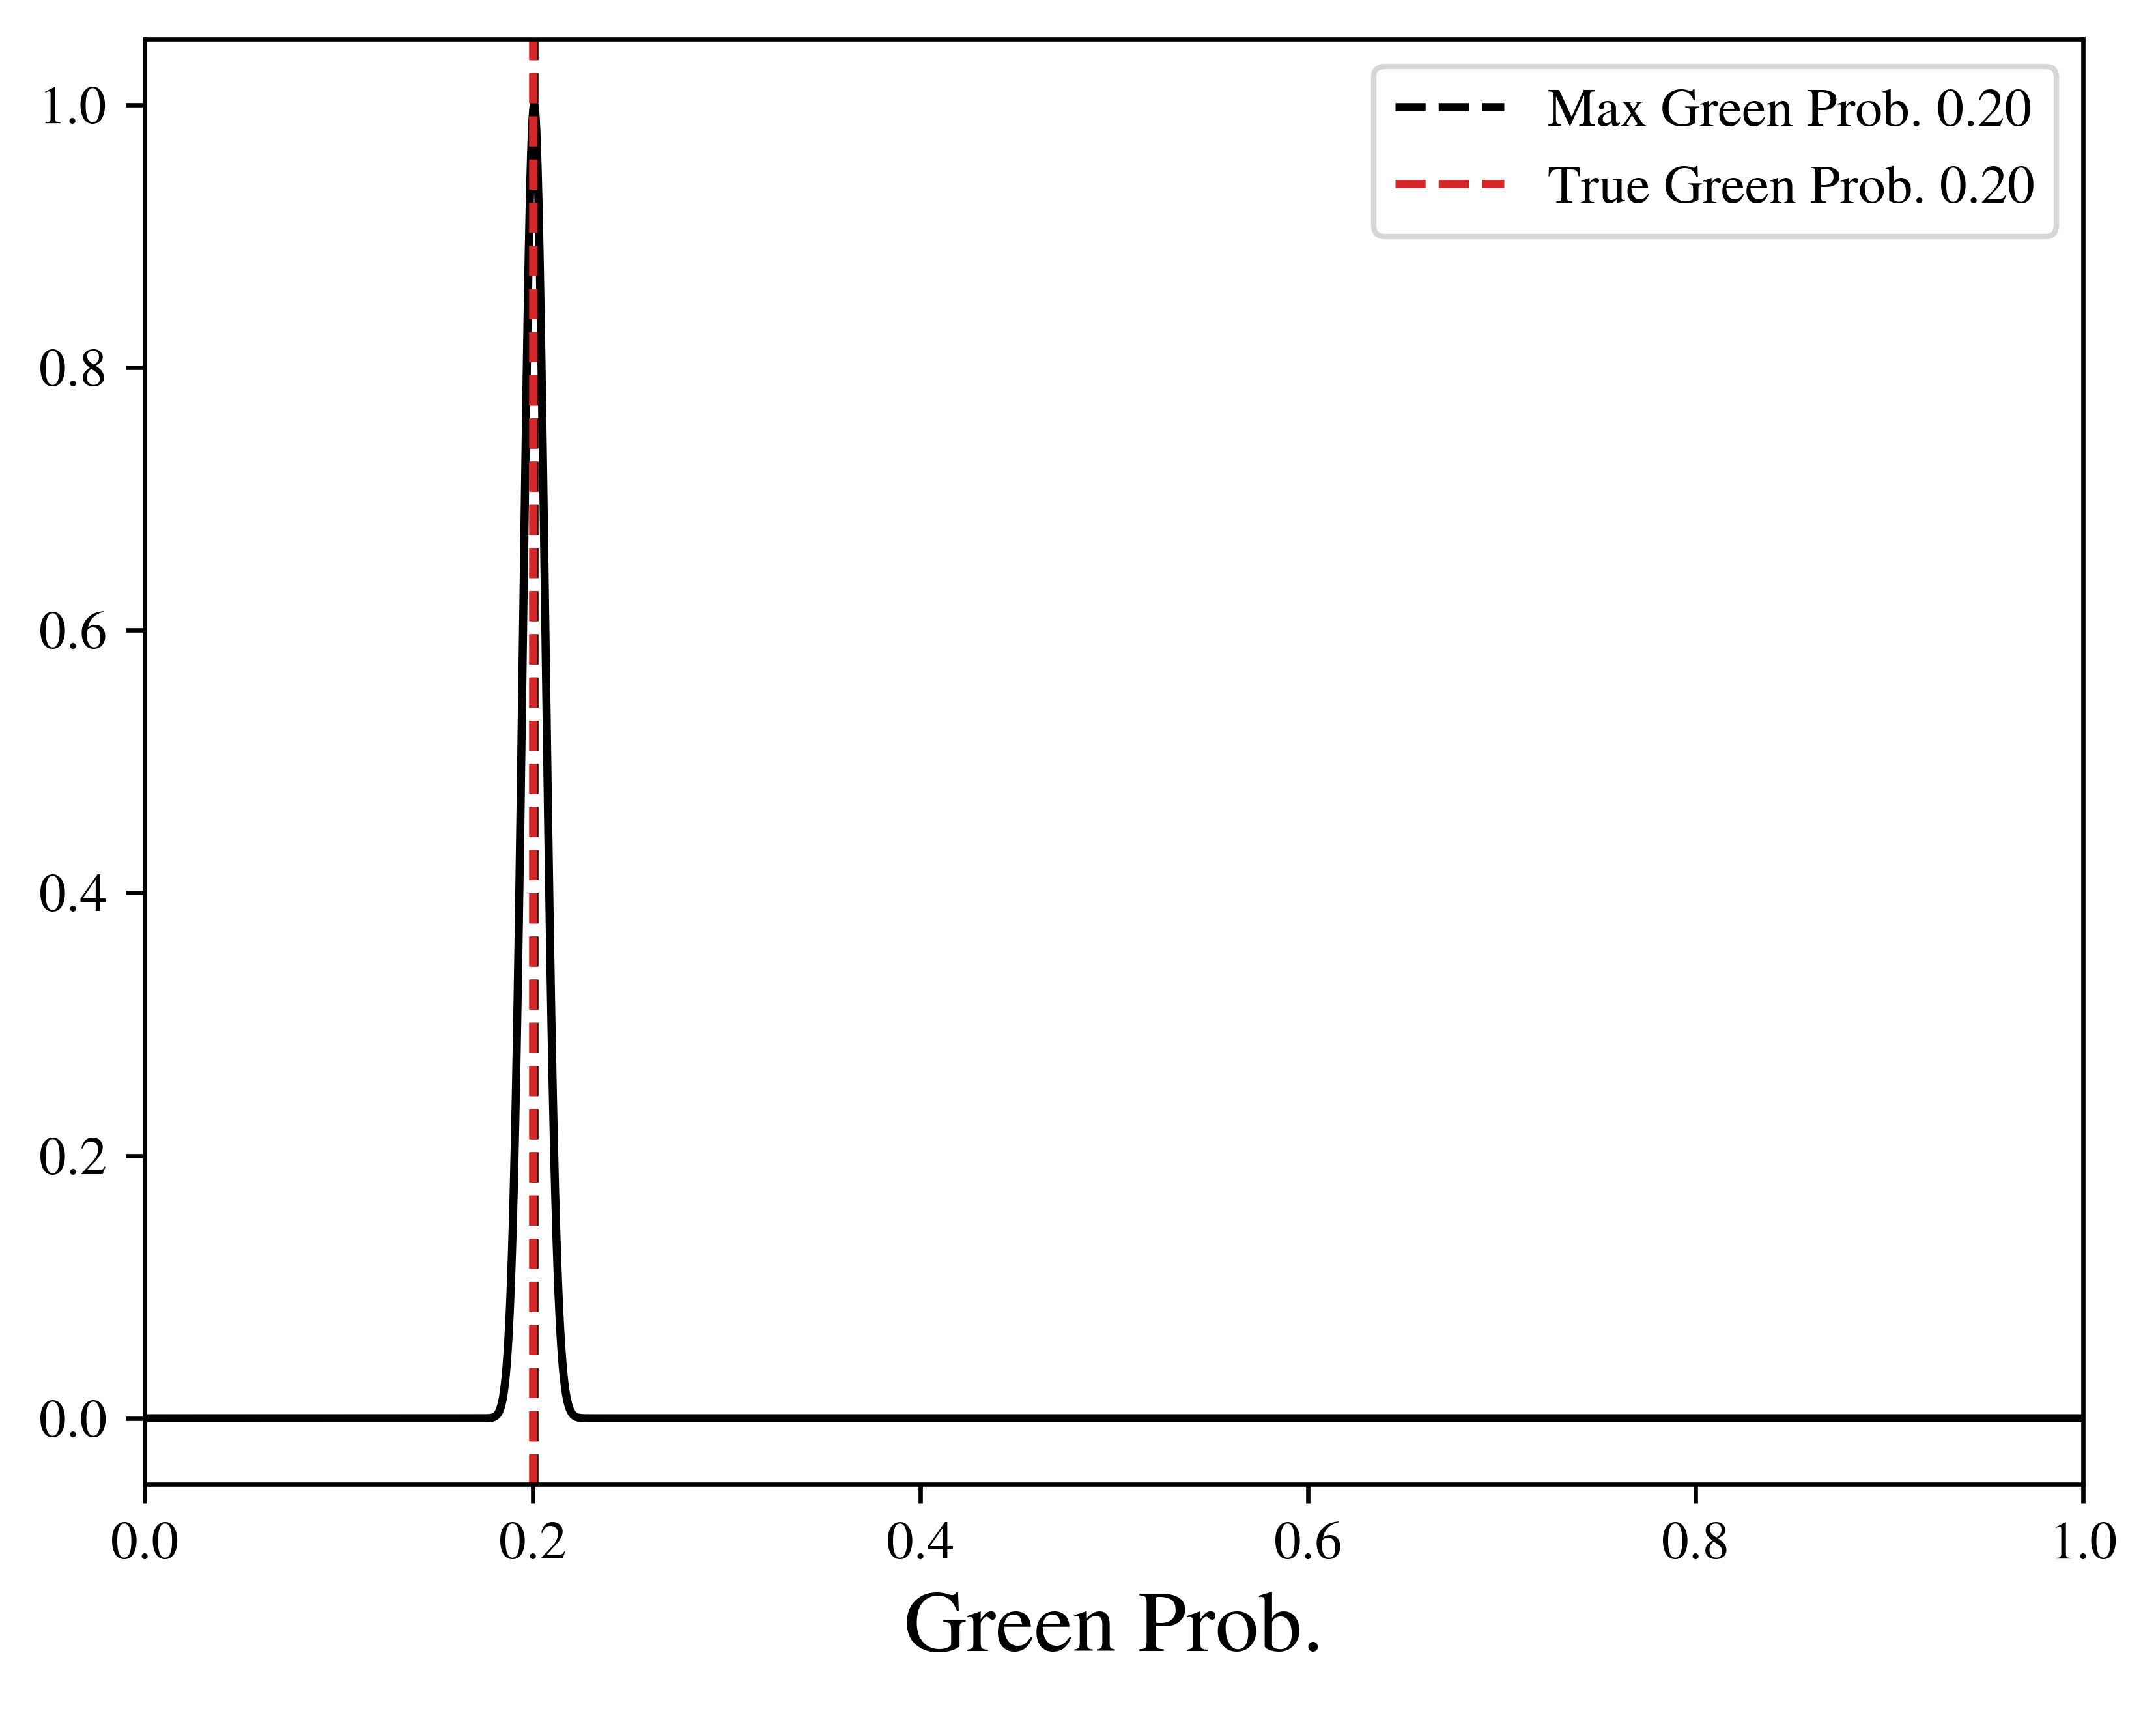

In [29]:
sample_size = 1000  # changeable
# grid size for probability grid
n_grid = 10000
# probability grid to consider
p_grid = np.linspace(0.001,0.999,n_grid)
# the uniform prior
green_prior = np.ones(n_grid)
gree_posterior = np.ones(n_grid)
# to track the number of draws 
n_draws = []

for i in range(sample_size):

    # define the parameters of our bag of marbles
    total_marbles = 100  # changeable
    original_total = total_marbles
    # number of green marbles
    total_green_marbles = 25  # changeable
    total_other_marbles = total_marbles - total_green_marbles

    # number of red marbles to remove
    n_cull = 4  # changeable
    # adjust total number of other marbles
    total_other_marbles -= n_cull

    # inherent green marble draw probability
    green_prob = 0.20  # changeable
    # 1-p
    other_prob = 1 - green_prob
    # compute weights for all marbles
    green_weights = np.ones(total_green_marbles) * green_prob / total_green_marbles #* (total_other_marbles/original_total)
    other_weights = np.ones(total_other_marbles) * other_prob / total_other_marbles #* (total_other_marbles/original_total)

    # construct of marble color strings (could just be binary I guess)
    marble_set = np.array(total_green_marbles * ['Green'] + total_other_marbles * ['Other'])
    # merge the weight arrays
    all_weights = np.concatenate((green_weights, other_weights))

    # convert the probability grid to odds ratio
    or_grid = (p_grid/total_green_marbles) / ((1-p_grid)/total_other_marbles)

    # generate the number and list of marbles that are be drawn in this sample
    # make sure one of 'sample =' below is uncommented. You can change the numbers within them
    # e.g., n_sample, mean, and n_limit
 
    # sample = draw_uniform(marble_set, draw_probs=all_weights, n_sample=10)  # draw a uniform number
    # sample = draw_poisson(marble_set, draw_probs=all_weights, mean=4)  # draw with a given Poisson mean
    sample = draw_limit(marble_set, green_prob, n_limit=1)  # draw until n_limit green are pulled

    n_draws.append(len(sample))
    n_sample = len(sample)

    # reset the count of green marbles, then count the number of green in sample
    n_green = 0
    for samp in sample:
        if samp == 'Green':
            n_green += 1

    # compute the likelihood using WNCH distribution
    green_likelihood = scipy.stats.nchypergeom_wallenius.pmf(n_green, len(marble_set), total_green_marbles, n_sample, or_grid)
    # update prostior
    green_posterior = green_likelihood * green_prior / np.max(green_likelihood * green_prior)
    # update next prior
    green_prior = green_posterior

fig, ax = plt.subplots()
ax.set_xlim(0,1)
print(f'True green prob: {green_prob:.2f}')
print(f'Max green prob: {p_grid[np.argmax(green_posterior)]:.2f}')
print(f'True odds ratio: {green_weights[0]/other_weights[0]:.2f}')
print(f'Max prob odds ratio: {or_grid[np.argmax(green_posterior)]:.2f}')
ax.plot(p_grid, green_posterior,'k')
ax.axvline(p_grid[np.argmax(green_posterior)],color='k',linestyle='--',label=f'Max Green Prob. {p_grid[np.argmax(green_posterior)]:.2f}')
ax.axvline(green_prob,color='C3',linestyle='--',label=f'True Green Prob. {green_prob:.2f}')
colors = ['C0','C1','C2','C3','C4','C5']
percs = [.1,.15,.20,.25,.3,.35]
#for i in range(len(percs)):
    #ax.axvline(percs[i]/total_green_marbles/((1-percs[i])/total_other_marbles),color=f'C{i}',linestyle='--',label=f'Green Prob. {percs[i]:.2f}')
    #ax.axvline(percs[i],color=f'C{i}',linestyle='--',label=f'Green Prob. {percs[i]:.2f}')
ax.set_xlabel('Green Prob.')
ax.legend()

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]


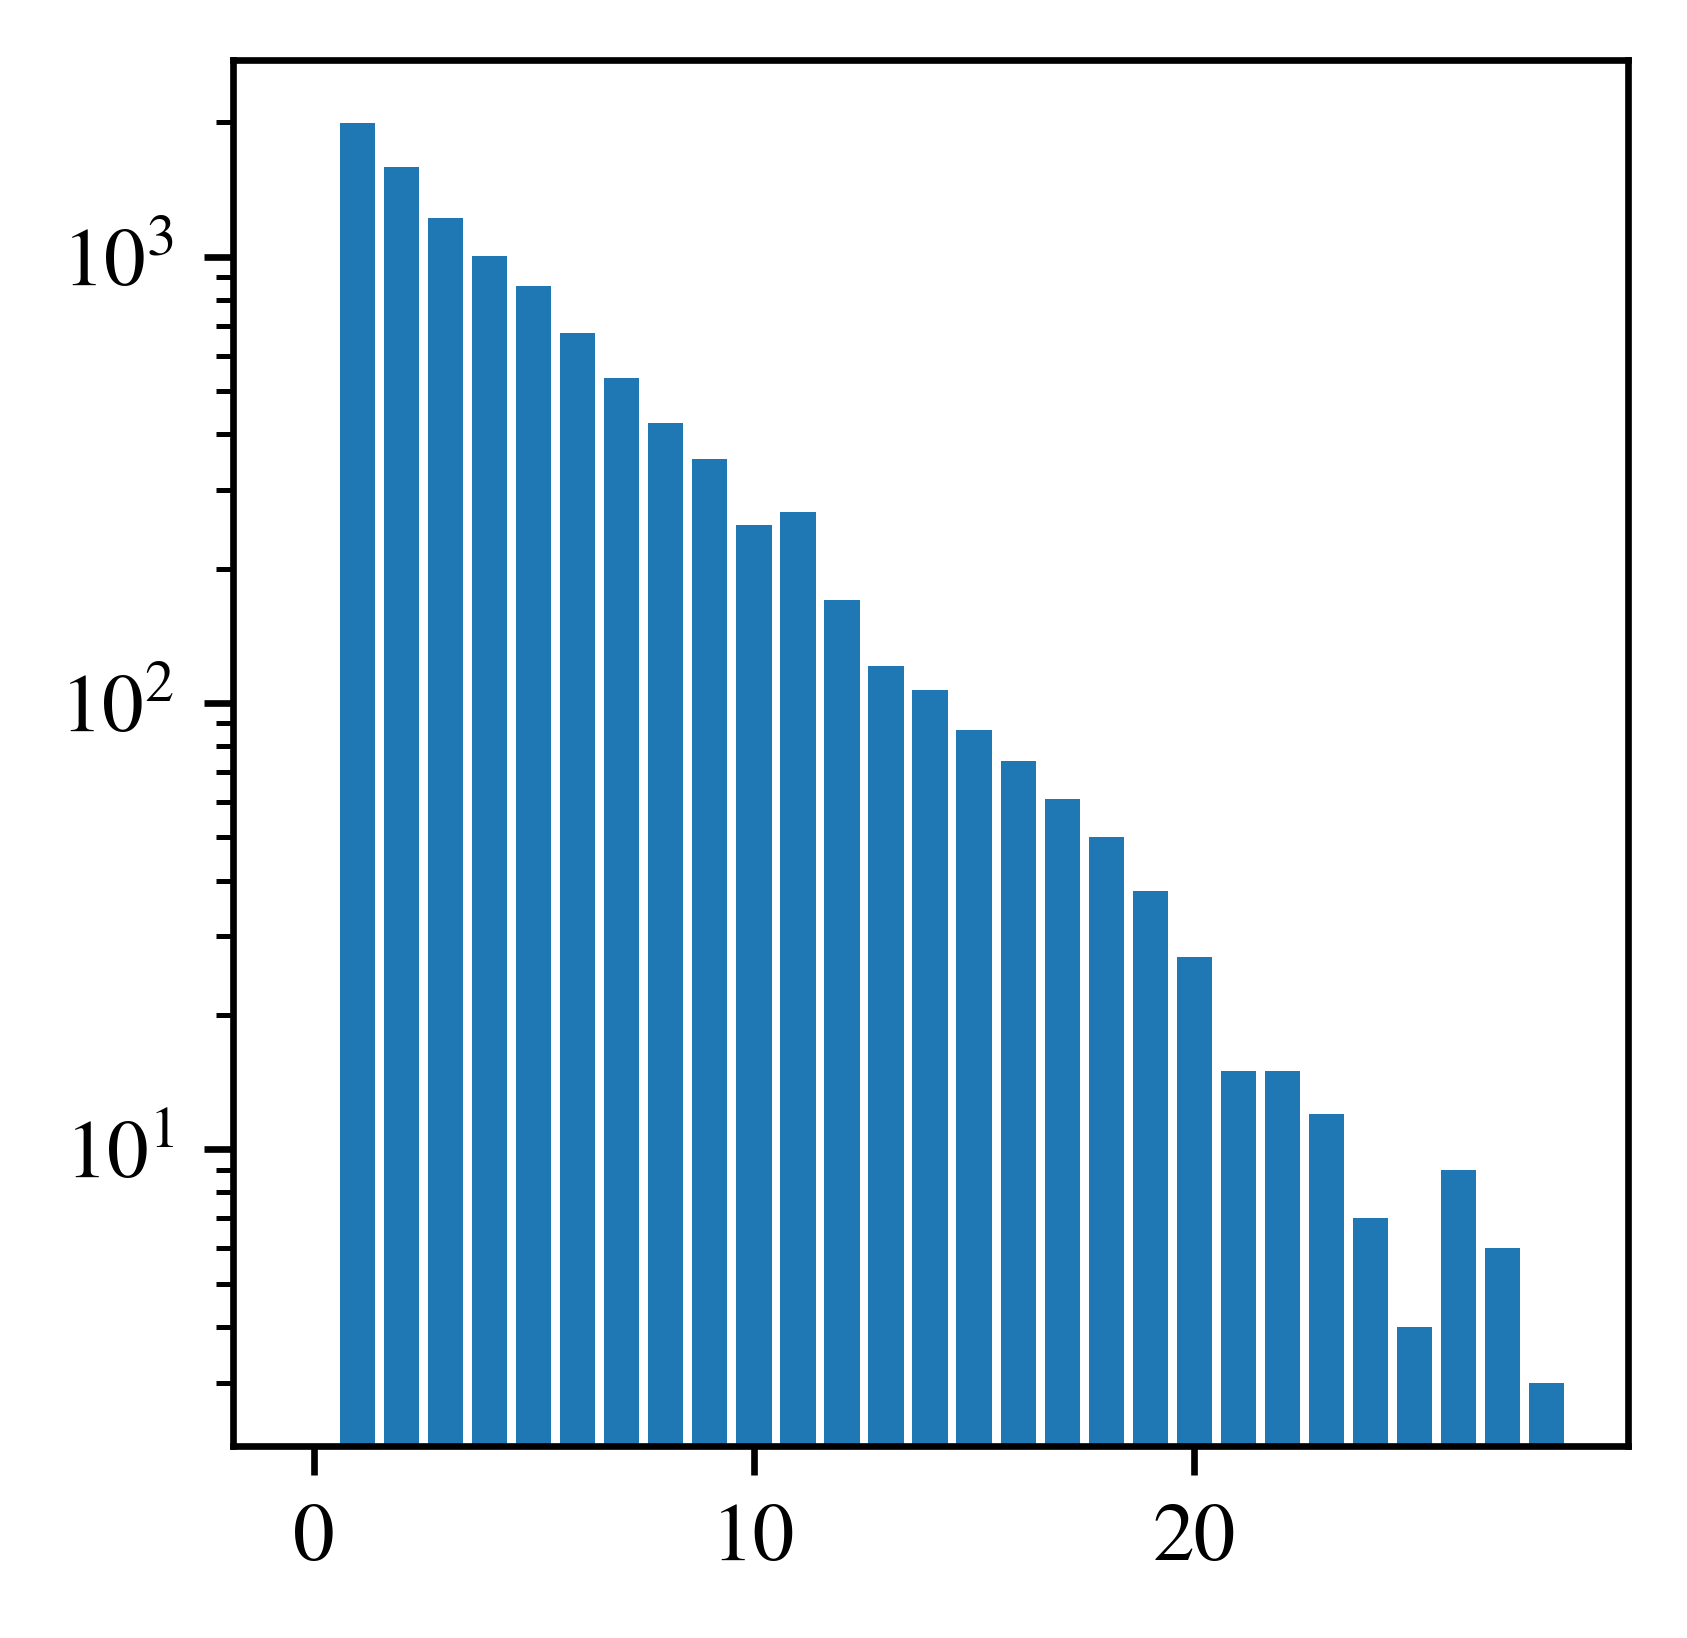

In [28]:
# just plitting up the distribution of draws
# TODO fit for expected number of draws
fig,ax = plt.subplots(figsize=(3,3))
bins = np.arange(30)-.5
bin_centers = (bins[1:] + bins[:-1])/2
hist, bins = np.histogram(np.array(n_draws),bins=bins)
print(bin_centers)

ax.bar(bin_centers,hist)
ax.set_yscale('log')

Text(0, 0.5, 'Probability $p$')

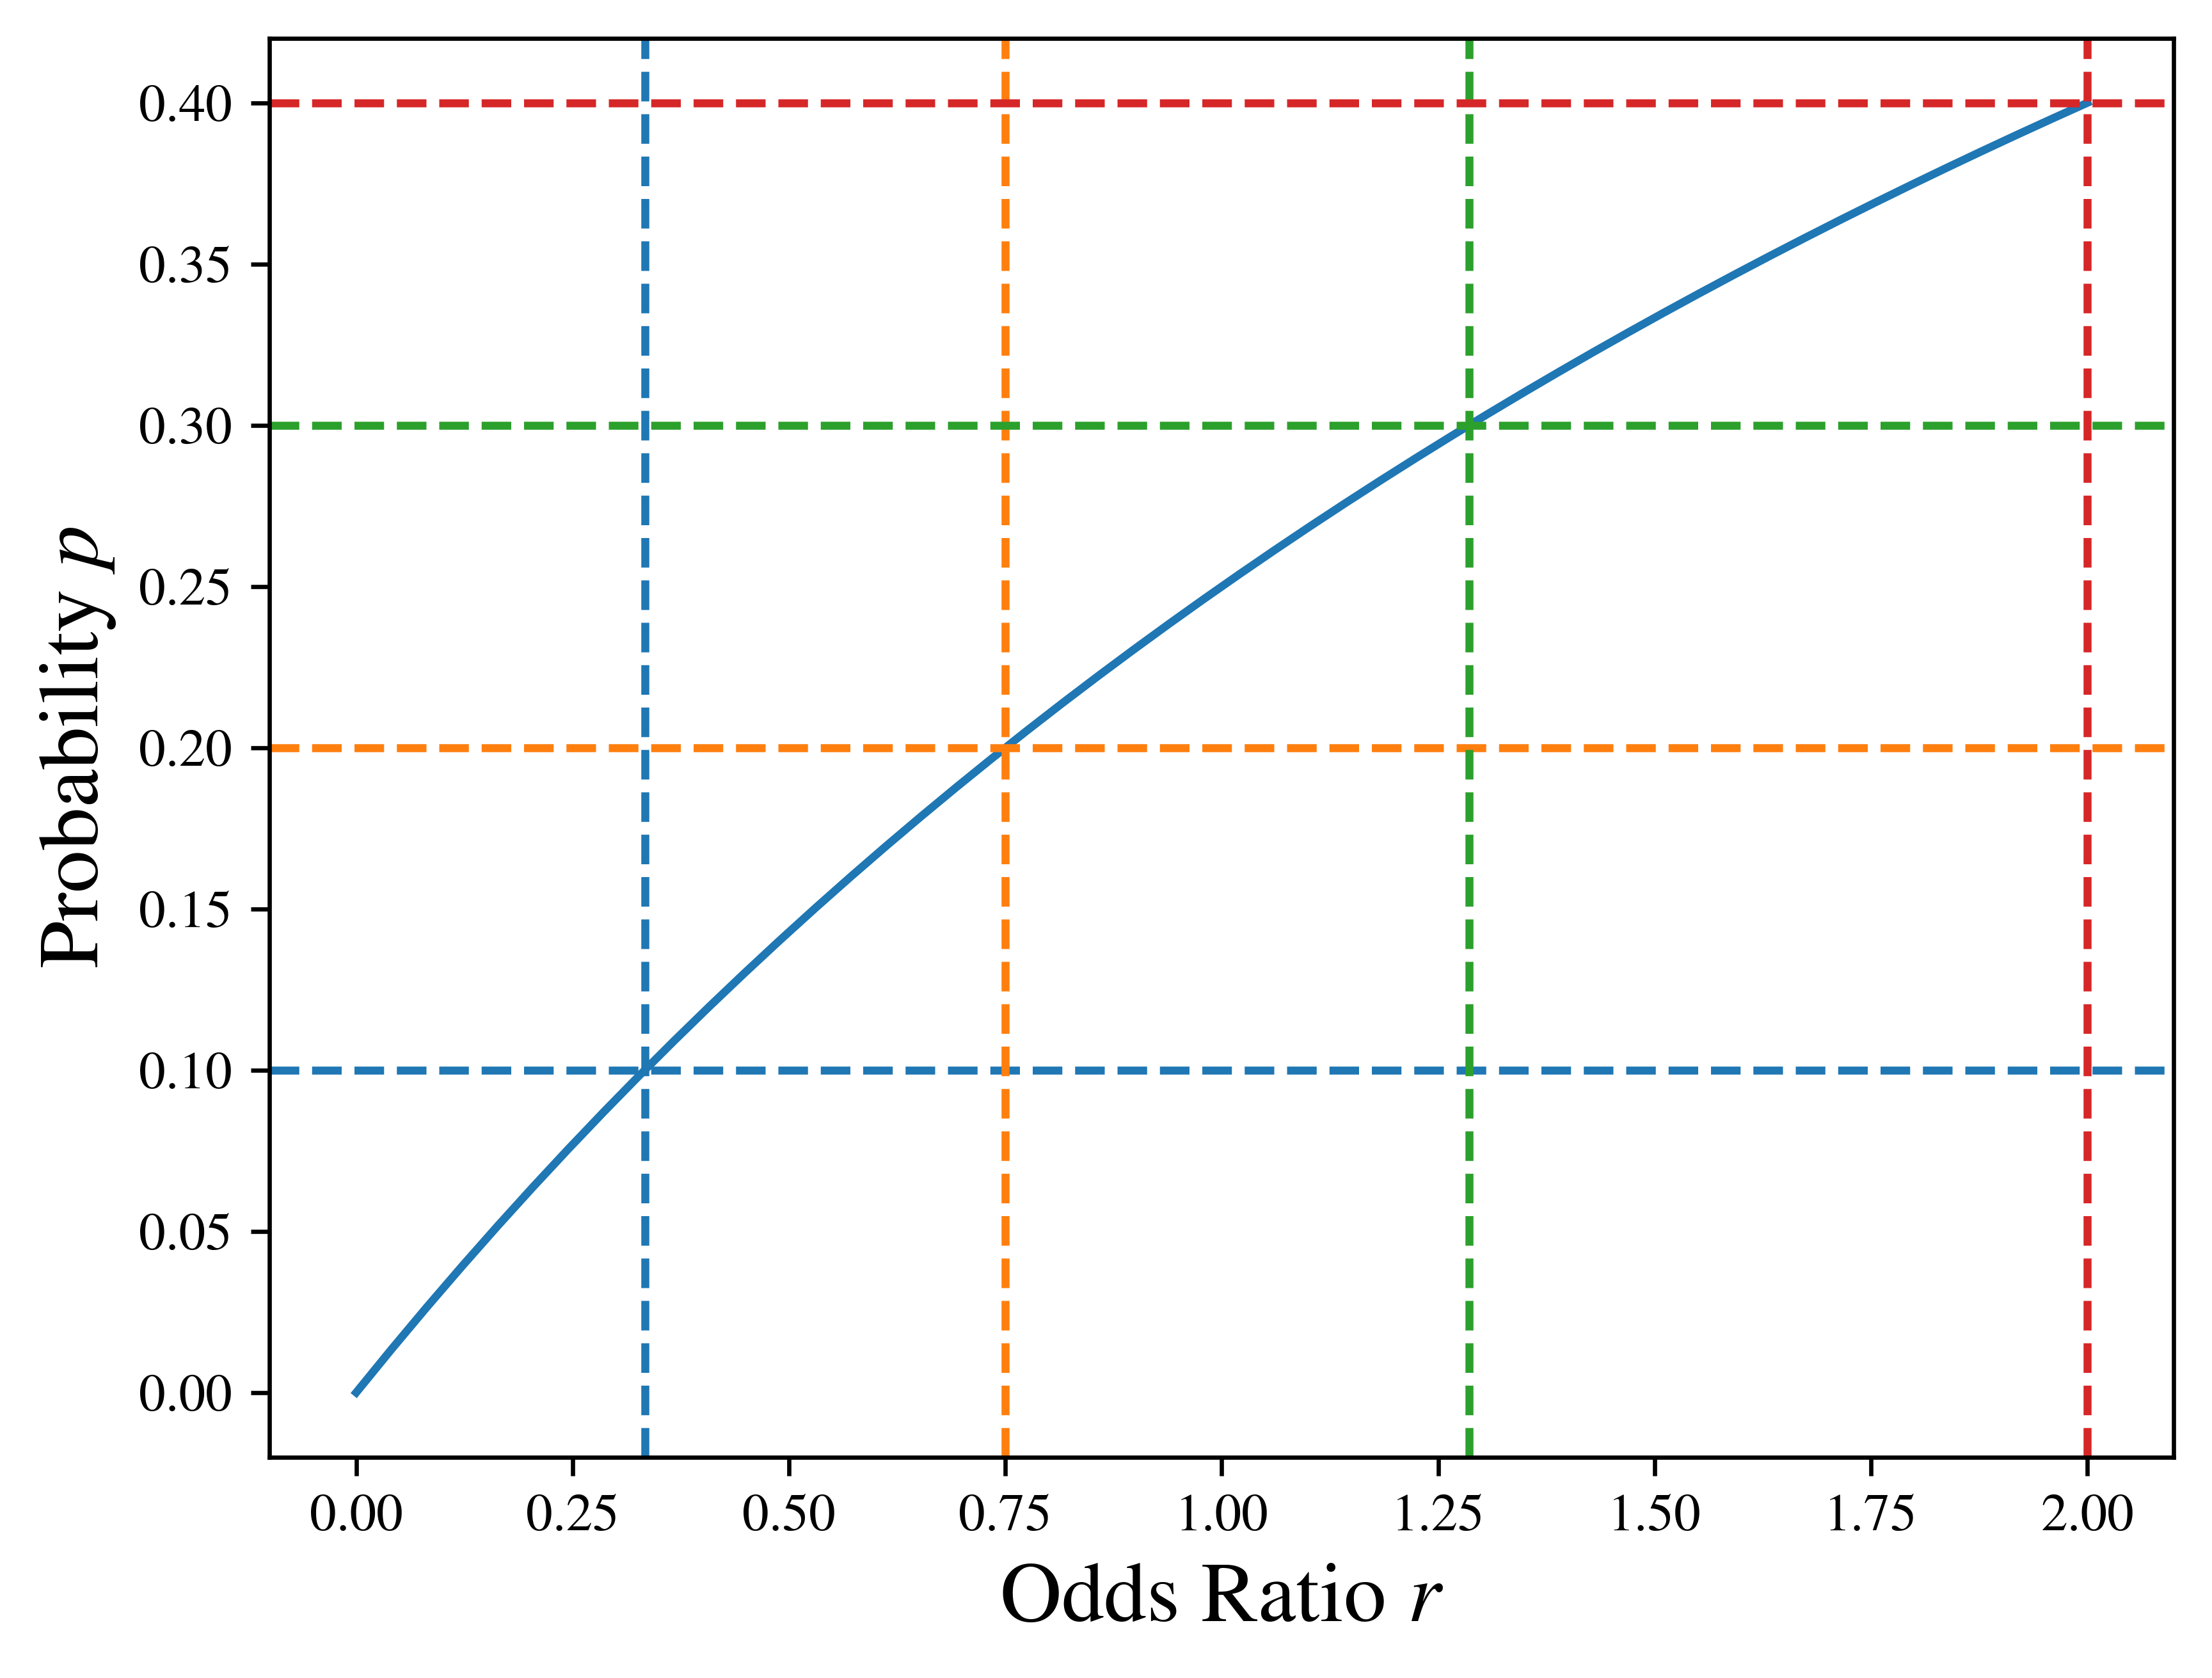

In [5]:
# just exploring the relationship between prob and odds ratio, leaving for posterity 
fig,ax = plt.subplots()
n_green = 25
n_total = 100
n_other = n_total - n_green
or_grid = np.linspace(0,2)
# prob over (1 - prob)
po1mp = or_grid * n_green / n_other
# solve for prob
p = po1mp / (1 + po1mp)
ax.plot(or_grid, p)
percs = [0.1,0.2,0.3,0.4,]
for i in range(len(percs)):
    ax.axvline(percs[i]/n_green/((1-percs[i])/n_other),color=f'C{i}',linestyle='--')
    ax.axhline(percs[i],color=f'C{i}',linestyle='--')
ax.set_xlabel(r'Odds Ratio $r$')
ax.set_ylabel(r'Probability $p$')

In [ ]:
# same as above, but pre-generate lists of draws and check each split number individually

sample_size = 1000  # changeable
# grid size for probability grid
n_grid = 10000
# probability grid to consider
p_grid = np.linspace(0.001,0.999,n_grid)
# the uniform prior
green_prior = np.ones(n_grid)
gree_posterior = np.ones(n_grid)
# to track the number of draws 
n_draws = []

for i in range(sample_size):

    # define the parameters of our bag of marbles
    total_marbles = 100  # changeable
    original_total = total_marbles
    # number of green marbles
    total_green_marbles = 25  # changeable
    total_other_marbles = total_marbles - total_green_marbles

    # number of red marbles to remove
    n_cull = 4  # changeable
    # adjust total number of other marbles
    total_other_marbles -= n_cull

    # inherent green marble draw probability
    green_prob = 0.20  # changeable
    # 1-p
    other_prob = 1 - green_prob
    # compute weights for all marbles
    green_weights = np.ones(total_green_marbles) * green_prob / total_green_marbles #* (total_other_marbles/original_total)
    other_weights = np.ones(total_other_marbles) * other_prob / total_other_marbles #* (total_other_marbles/original_total)

    # construct of marble color strings (could just be binary I guess)
    marble_set = np.array(total_green_marbles * ['Green'] + total_other_marbles * ['Other'])
    # merge the weight arrays
    all_weights = np.concatenate((green_weights, other_weights))

    # convert the probability grid to odds ratio
    or_grid = (p_grid/total_green_marbles) / ((1-p_grid)/total_other_marbles)

    # generate the number and list of marbles that are be drawn in this sample
    # make sure one of 'sample =' below is uncommented. You can change the numbers within them
    # e.g., n_sample, mean, and n_limit
 
    # sample = draw_uniform(marble_set, draw_probs=all_weights, n_sample=10)  # draw a uniform number
    # sample = draw_poisson(marble_set, draw_probs=all_weights, mean=4)  # draw with a given Poisson mean
    sample = draw_limit(marble_set, green_prob, n_limit=1)  # draw until n_limit green are pulled

    n_draws.append(len(sample))
    n_sample = len(sample)

    # reset the count of green marbles, then count the number of green in sample
    n_green = 0
    for samp in sample:
        if samp == 'Green':
            n_green += 1

    # compute the likelihood using WNCH distribution
    green_likelihood = scipy.stats.nchypergeom_wallenius.pmf(n_green, len(marble_set), total_green_marbles, n_sample, or_grid)
    # update prostior
    green_posterior = green_likelihood * green_prior / np.max(green_likelihood * green_prior)
    # update next prior
    green_prior = green_posterior

fig, ax = plt.subplots()
ax.set_xlim(0,1)
print(f'True green prob: {green_prob:.2f}')
print(f'Max green prob: {p_grid[np.argmax(green_posterior)]:.2f}')
print(f'True odds ratio: {green_weights[0]/other_weights[0]:.2f}')
print(f'Max prob odds ratio: {or_grid[np.argmax(green_posterior)]:.2f}')
ax.plot(p_grid, green_posterior,'k')
ax.axvline(p_grid[np.argmax(green_posterior)],color='k',linestyle='--',label=f'Max Green Prob. {p_grid[np.argmax(green_posterior)]:.2f}')
ax.axvline(green_prob,color='C3',linestyle='--',label=f'True Green Prob. {green_prob:.2f}')
colors = ['C0','C1','C2','C3','C4','C5']
percs = [.1,.15,.20,.25,.3,.35]
#for i in range(len(percs)):
    #ax.axvline(percs[i]/total_green_marbles/((1-percs[i])/total_other_marbles),color=f'C{i}',linestyle='--',label=f'Green Prob. {percs[i]:.2f}')
    #ax.axvline(percs[i],color=f'C{i}',linestyle='--',label=f'Green Prob. {percs[i]:.2f}')
ax.set_xlabel('Green Prob.')
ax.legend()